# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Нам необходимо построить модель, которая по фотографии определит приблизительный возраст человека. «Хлеб-Соль» предоставили в наше распоряжение набор фотографий людей с указанием их возраста.


Для решения поставленной задачи будем придерживатья следующих шагов:

- Проведём исследовательский анализ набора фотографий.
- Подготовим данные к обучению
- Обучим нейронную ресть и рассчитаем её качество. 
  - в качестве метрики будем использовать ```MAE``` (Mean Absolute Error) - метрику, измеряющую среднее абсолютное отклонение между предсказанными значениями и фактическими, она вычисляется по формуле: 
  $$MAE = \frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i|$$
  - Буквально ```MAE``` будет представлять собой меру ошибки между попарными наблюдениями возраста и чем ближе значение ```MAE``` к нулю, тем меньше ошибка предсказания. Наша цель - создать такую модель, которая ошибалась бы не больше, чем на 8 лет.
- Подведём итог проделанной работе

_____

Импортируем все необходимые для работы библиотеки и модули:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

RANDOM_STATE = 42
BATCH_SIZE = 32

Техническая часть работы - некоторые функции и рабочие части кода соберём в одном месте здесь наверху, так общий код исследования будет выглядеть аккуратнее:

In [2]:
def get_hist(col, xlabel, ylabel, title, rotation=0):
    """Функция отрисовывает график распределения"""
    
    mean_age = col.mean()
    min_age = col.min()
    max_age = col.max()
    best_age = col.value_counts().idxmax()
    
    plt.figure(figsize=(17,7))
    sns.kdeplot(col, color='#4633FF', shade=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontweight='bold')
    plt.xticks(rotation=rotation)
    
    plt.axvline(x=mean_age, label=f'средний возраст={int(mean_age)}', lw=1.5, c='#4633FF')
    plt.axvline(x=min_age, label=f'минимальный возраст={int(min_age)}', lw=1.5, c='#4633FF')
    plt.axvline(x=max_age, label=f'максимальный возраст={int(max_age)}', lw=1.5, c='#4633FF')
    plt.axvline(x=best_age, label=f'самый популярный возраст={int(best_age)}', lw=1.5, c='#C21D8B')
    
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', axis='y', linewidth=.25, linestyle='--');
    
    
def print_photo(features, target):
    """Функция печатает 25 фотографий в фигуре 5x5"""
    
    fig = plt.figure(figsize=(17, 17))
    fig.suptitle('образцы фотографий и возраст людей на фото', 
                 fontsize=16, fontweight='bold')
    for i in range(25):
        fig.add_subplot(5, 5, i+1)
        plt.imshow(features[i])
        plt.title(target[i])
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout();
    
    
def get_info(df):
    """
    Функция возвращает обзор датасета - первые и последние строки, 
    описание, количество пропусов, явных дубликатов
    """
    
    display(df.head(3), df.tail(3), df.describe().T)
    print(f'размер: {df.shape}\n\nпропуски:\n{df.isna().sum()}\n\nдубликатов: {df.duplicated().sum()}')

_____

Загрузим данные:

In [3]:
try:
    df = pd.read_csv('/datasets/faces/labels.csv')
except FileNotFoundError:
    print('что-то пошло не так')

создадим генератор и загрузим фотографии с метками возраста:

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255) 

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        seed=RANDOM_STATE)

Found 7591 validated image filenames.


## Исследовательский анализ данных

Исследуем датасет:

In [5]:
get_info(df)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


,file_name,real_age
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


размер: (7591, 2)

пропуски:
file_name    0
real_age     0
dtype: int64

дубликатов: 0


видим, что дело имеем с двумя столбцами - это: 
- ```file_name``` - название .jpg-файла в хралилице
- ```real_age``` - реальный возраст человека на фото, наш таргет

строк 7590 шт., пропусков в данных нет, явные дубликаты отсутствуют. Такого количества должно быть достаточно для обучения модели. 

$\Rightarrow$ супермаркет «Хлеб-Соль» нас не обманул и файл с данными не перепутал, всё как надо.

Построим график распределения возраста и посмотрим на то, с каким возрастом нам предстоит иметь дело:

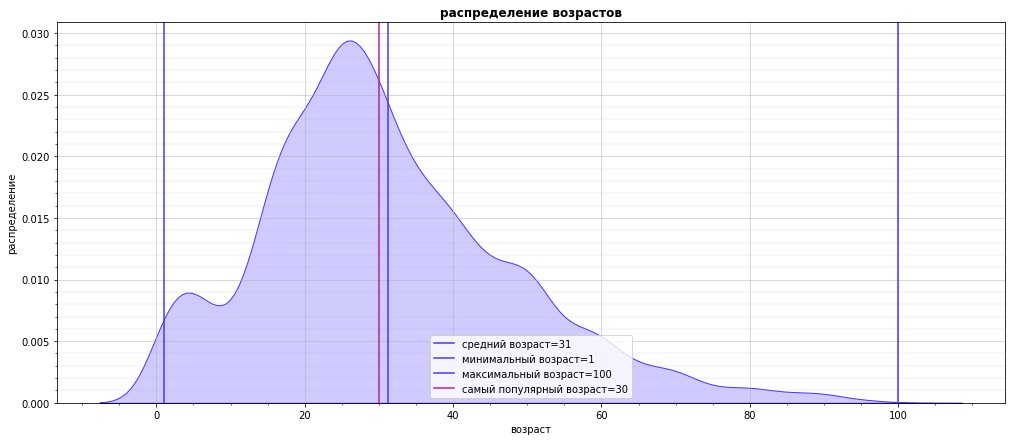

In [6]:
get_hist(df['real_age'], 'возраст', 'распределение', 'распределение возрастов')

и стар и млад, все у нас есть! от годовалых карапузов, до почтенных долгожителей. Средний возраст посетителя «Хлеба-Соли» 31 год, а больше всего 30-летних покупателей, что похоже на правду, т.к. это довольно молодая и активная возрастная группа, самая что ни на есть целевая аудитория любого супермаркета.

Хвост вправо в распределдении вполне объясним, т.к. супермаркет у нас «Хлеб-Соль», а и хлеб и соль - это то, без чего вряд ли получится протянуть до 100-летнего юбилея.

А вот небольшой пик с левой стороны распределения рациональной интерпретации с точки зрения бизнес-логики поддаётся сложнее $\Rightarrow$ для понимания имеющихся в нашем распоряжении фотографий попробуем выборочно посмотреть на некоторые из них и понять, кто же на них запечатлен и в каком интерьере:

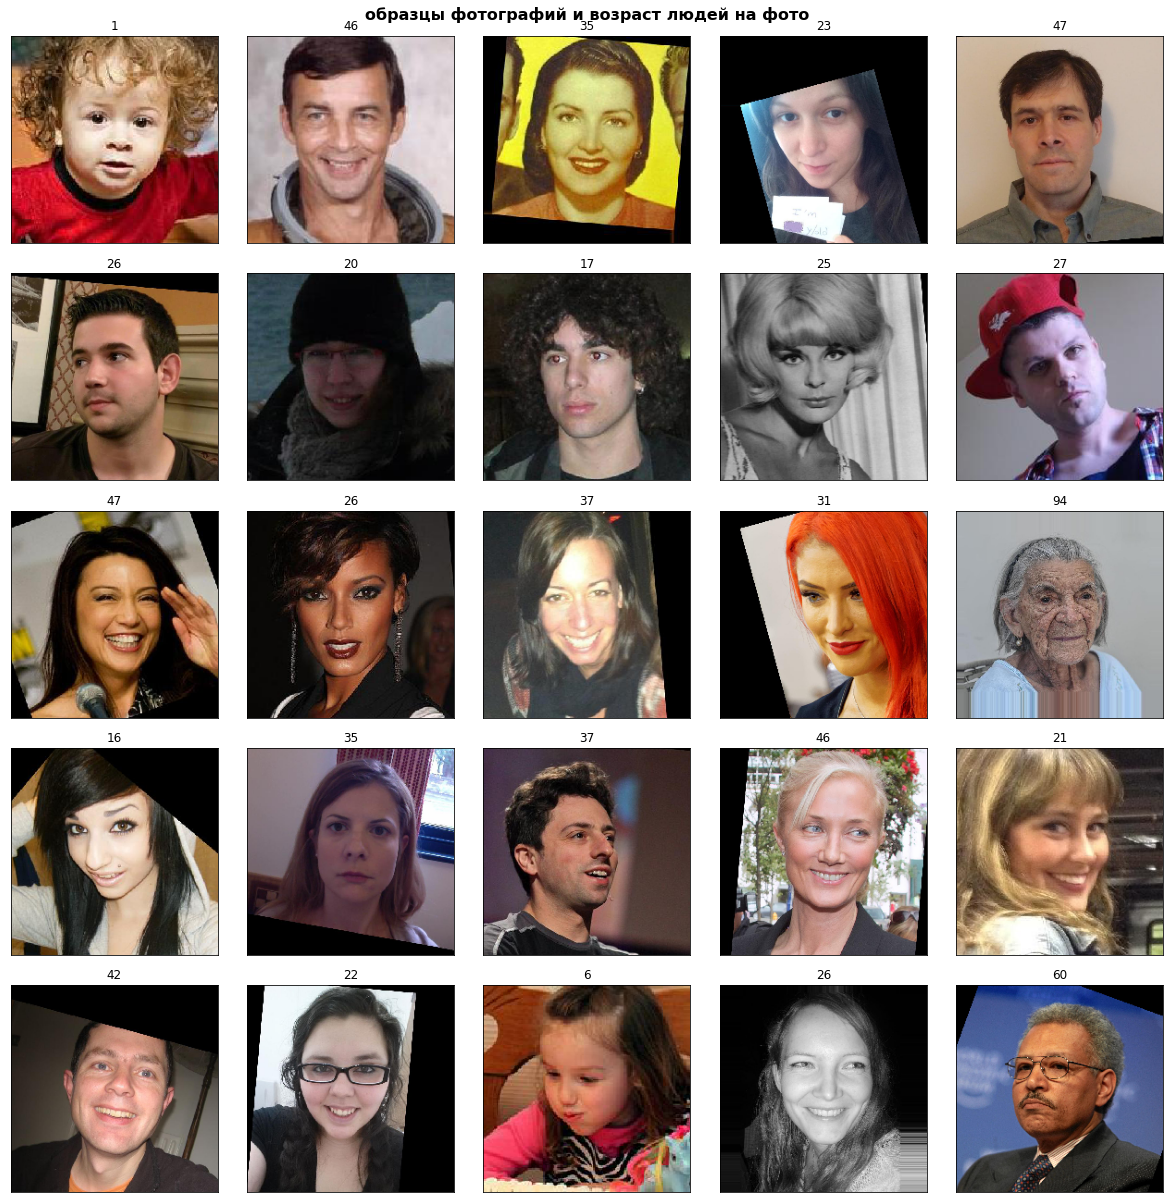

In [7]:
X, y = next(train_gen_flow)
print_photo(X, y)

что можно понять по выведенным фотографиям:
- фото сделаны явно не в интерьере магазина, а значит нам следует временно абстрагироваться от торговой темы и просто научиться определять возраст по фотографиям. Возможно, в будущем стоило бы предложить супермаркету «Хлеб-Соль» собрать свою базу фото покупателей и дообучить модель
- такой подбор фото частично объясняет то, что на них можно встретить и годовалых карапузов, но для задачи определения возраста и малыши будут полезны. Юные посетители магазина обычно приходят с родителями, а молодые родители - особая социальная группа, значит на их детей тоже стоит реагировать и фото с ними нельзя считать выбросами
- касаемо самих фото - мы явно видим то, что фотографии, оказавшиеся в нашем распоряжении, самые разные:
  - есть скошенные фото
  - засвеченные
  - чёрно-белые
  - отдельные фото настолько старые, что можно предположить, что на фото №4 во втором ряду и фото №5 в третьем ряду один и тот же человек))
  - смазанные
  - на некоторых фото можно видеть всякие очки и шапки
  - и бывает, что на фото попадаются другие обрезанные люди
  - наверняка ещё много интересного встретит ML-модель при обучении

- одно кажется верным - субъективно метка возраста фотографии соответствует человеку на ней, а значит в этой зоне сильных ошибок возникать не должно  
- также стоит помнить о распределении возраста в имеющихся у нас данных, модель будет склонна метить в самую популярную возрастную группу в 25-35 лет и об этом факте следует помнить при формировании алгоритма обучения  
- для аугментации за основу оттолкнёмся от того, что все нюансы так или иначе нам не ухватить, так как задавая чрезмерно глубокую настройку мы рискуем переобучить модель, однако нельзя не отметить тот факт, что многие из увиденных нами фотографий так или иначе имеют какой-то наклон - либо наклон рамки на фотографии либо наклон головы. Увы, люди не синхронны, поэтому модели мы подадим оригинальные фотографии и фотографии с лёгким до (10% максимум) поворотом.

_____

**Предварительный вывод. На данном этапе мы:**

- сформулировали стоящую перед намит задачу
- загрузили данные и познакомились с ними
- определили некоторые особенности имеющихся в нашем распоряжении фотографий. Будем стараться учитывать эти особенности при подготовки модели машинного обучения, используя аугментацию данных. Она полжна помочь модели научиться обобщать и распознавать лица в различных условиях, что, в свою очередь, должно улучшить точность предсказания возраста

$\Rightarrow$ данные изучены и готовы к обучению. Мы можем переходить к моделированию

_____

## Обучение модели

вот код обучения модели:

<div style="border:solid Green 2px; padding: 40px">

    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications.resnet import ResNet50
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.optimizers import Adam
    import pandas as pd

    RANDOM_STATE = 42


    def load_train(path, seed=RANDOM_STATE):

        labels = pd.read_csv(path + 'labels.csv')

        train_datagen = ImageDataGenerator(
            validation_split=0.25,
            rescale=1. / 255,
            rotation_range=10,            # угол в градусах
            horizontal_flip=True,         # отражение по горизонтали
        )

        train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=seed
        )

        return train_gen_flow


    def load_test(path, seed=RANDOM_STATE):
        labels = pd.read_csv(path + 'labels.csv')
        test_datagen = ImageDataGenerator(
            validation_split=0.25,
            rescale=1./255
        )

        test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=seed
        )

        return test_gen_flow


    def create_model(input_shape, optimizer=Adam(lr=0.0001)):

        model = Sequential([
            ResNet50(weights='imagenet', input_shape=input_shape, include_top=False),
            GlobalAveragePooling2D(),
            Dropout(0.1),
            Dense(1, activation='relu')
        ])
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

        return model


    def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                    steps_per_epoch=None, validation_steps=None):

        model.fit(
            train_data,
            validation_data=test_data,
            batch_size=batch_size,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2
        )

        return model
    
</div>

_____

а вот вывод результатов обучения модели:

<div style="border:solid Green 2px; padding: 40px">

    Found 5694 validated image filenames.
    Found 1897 validated image filenames.

    Train for 178 steps, validate for 60 steps
    Epoch 1/20

    178/178 - 94s - loss: 237.9181 - mae: 10.8977 - val_loss: 808.6101 - val_mae: 23.4232
    Epoch 2/20
    178/178 - 86s - loss: 85.7249 - mae: 6.9902 - val_loss: 652.9352 - val_mae: 20.2808
    Epoch 3/20
    178/178 - 87s - loss: 61.9119 - mae: 5.9738 - val_loss: 305.4520 - val_mae: 13.0537
    Epoch 4/20
    178/178 - 87s - loss: 48.7720 - mae: 5.3271 - val_loss: 119.4889 - val_mae: 8.3584
    Epoch 5/20
    178/178 - 87s - loss: 39.2210 - mae: 4.8221 - val_loss: 79.7685 - val_mae: 6.6022
    Epoch 6/20
    178/178 - 86s - loss: 31.9306 - mae: 4.3626 - val_loss: 104.0638 - val_mae: 7.7088
    Epoch 7/20
    178/178 - 87s - loss: 26.9858 - mae: 4.0365 - val_loss: 69.2161 - val_mae: 6.3437
    Epoch 8/20
    178/178 - 87s - loss: 24.6590 - mae: 3.8099 - val_loss: 102.0535 - val_mae: 8.0097
    Epoch 9/20
    178/178 - 86s - loss: 20.5434 - mae: 3.4934 - val_loss: 70.4127 - val_mae: 6.2559
    Epoch 10/20
    178/178 - 86s - loss: 17.4517 - mae: 3.2059 - val_loss: 71.0847 - val_mae: 6.1807
    Epoch 11/20
    178/178 - 92s - loss: 15.2668 - mae: 3.0225 - val_loss: 65.1562 - val_mae: 5.9591
    Epoch 12/20
    178/178 - 88s - loss: 12.8799 - mae: 2.7489 - val_loss: 68.7746 - val_mae: 6.0747
    Epoch 13/20
    178/178 - 91s - loss: 13.3958 - mae: 2.7642 - val_loss: 73.4324 - val_mae: 6.4986
    Epoch 14/20
    178/178 - 89s - loss: 12.7999 - mae: 2.7089 - val_loss: 69.9180 - val_mae: 6.1023
    Epoch 15/20
    178/178 - 93s - loss: 11.8140 - mae: 2.6214 - val_loss: 75.9879 - val_mae: 6.2705
    Epoch 16/20
    178/178 - 97s - loss: 10.5506 - mae: 2.4809 - val_loss: 63.5058 - val_mae: 5.9236
    Epoch 17/20
    178/178 - 89s - loss: 9.7461 - mae: 2.3826 - val_loss: 62.1276 - val_mae: 5.8508
    Epoch 18/20
    178/178 - 90s - loss: 9.1807 - mae: 2.3034 - val_loss: 60.0351 - val_mae: 5.7309
    Epoch 19/20
    178/178 - 89s - loss: 8.9767 - mae: 2.2826 - val_loss: 62.8102 - val_mae: 5.8280
    Epoch 20/20
    178/178 - 89s - loss: 9.5104 - mae: 2.3583 - val_loss: 61.8678 - val_mae: 5.7776

    60/60 - 10s - loss: 61.8678 - mae: 5.7776
    Test MAE: 5.7776   
    
</div>

Мы смогли добиться значения ```MAE``` на валидационной выборке = 5.7776 Это значение не превышает контрольного порога ```MAE``` = 8, а значит нейросеть справилась с поставленной задачей.

_____

**Предварительный вывод. На данном этапе мы:**

- написали код, использующий для обучения и предсказания предобученную свёрточную нейронную сеть ```ResNet50```
- дообучили нейросеть на наших фотография с генерацией новых фото на тренировочном наборе при помощи техники аугментации
- замерили качество предсказания, получили подходящее значение ```MAE``` = 5.7776

$\Rightarrow$ модель готова, она работает и показывает хорошие результаты, мы можем презентовать её заказчику.

_____

## Анализ обученной модели и общий вывод

По запросу супермаркета «Хлеб-Соль» мы разработали модель машинного обучения, которая может определять возрастную группу покупателя супермаркета по его фотографии. Для реализации данной модели нами были проделаны следующие шаги:
- изучены предоставленные данные
- выбран алгорит обучения - это ```ResNet50``` - глубокая сверточная нейронная сеть, состоящая из слоёв свёртки, соединённых между собой в каскад. Нейросеть ```ResNet50``` популярна и используется во многих приложениях, включая компьютерное зрение, распознавание речи и естественный язык.
- к обучению нейросети ```ResNet50``` мы добавили дополнительные сгенерированные данные, созданные путём аугментации имеющихся фотографий, т.е. создали копии имеющихся фото, но в случайном режиме добавили к этим копиям горизонтальное отражение и небольшой угол наклона

В качестве дальнейшей рекомендации предлагаем «Хлебу-Соли» собрать свой банк с фотографиями посетителей и дообучить модель на фотографиях, сделанных непосредственно на территории супермаркета. Это позволит улучшить точность предсказаний алгоритма в будущем.

А на сегодняшний день мы готовы предложить супермаркету взять в разработку модель, которая показала значение метрики MAE на валидационных данных равное 5.7 при допустимом пороге в 8. Это значит то, что наша модель может определить возрастную группу покупателя супермаркета с точностью до ±5.5 лет. Такая точность может быть использована супермаркетом «Хлеб-Соль» для улучшения взаимодействия с клиентами, разработки кастомизированных маркетинговых стратегий на разные возрастные группы покупателей, для отслеживания их поведения и мн.др. 

Надеемся, что наша модель поможет «Хлебу-Соли» улучшить качество обслуживания клиентов, повысить удовлетворенность покупателей и увеличить прибыльность бизнеса.

_____